Code to run model parameter recovery tests

In [1]:
%matplotlib inline
import os
import glob

import numpy as np
import pandas as pd
import scipy
from scipy import stats as ss
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import least_squares
from scipy.io import loadmat

import sys
sys.path.append('/project/3014018.02/analysis_mri/'+
            'DataSharingCollection/Code/1.Behavior-FitModels/Functions/')
import choiceModels, costFunctions, penalizedModelFit

base_dir = '/project/3014018.02/analysis_mri/DataSharingCollection'

## Run

In [46]:
dat = pd.read_csv(os.path.join(base_dir,'Data/1.TaskBehavior/trialSet.csv'),header=0,index_col=0)
dat.columns = ['inv','mult']
dat.head()
thetaPhiLen = 57
niter = 1000
results = pd.DataFrame(columns=['trueTheta','truePhi','recovTheta','recovPhi','cost','r'])
for i in range(thetaPhiLen):
    print i,
    trueTheta, truePhi = [scipy.random.uniform()/2,scipy.random.uniform()/5-0.1]
    trueDat = dat.copy()
    for j,trial in trueDat.iterrows():
        inv,mult = trial
        trueDat.loc[j,'ret'] = choiceModels.MP_model_ppSOE(inv,mult,0,trueTheta,truePhi)
    trueDat['exp'] = 0
#     Now fit
    fitIters = np.zeros([niter,5])
    for i in range(niter):
        param0 = [scipy.random.uniform()/2,scipy.random.uniform()/5-0.1]
        fitIters[i,0:2] = param0[:]
        res_lsq = least_squares(costFunctions.MP_ppSOE_costfun, param0, args=(trueDat,),
                                kwargs={'printStep':False,'resid_share':False},
                                diff_step=.05,bounds=([0,-.1],[.5,.1]),)
        theta,phi = res_lsq.x
        cost = res_lsq.cost
        fitIters[i,2:5] = [theta,phi,cost]
    cost_selected = np.min(fitIters[:,4]) #Minimal cost
    recovTheta = fitIters[fitIters[:,4]==cost_selected,2][0] # First theta with minimal cost
    recovPhi = fitIters[fitIters[:,4]==cost_selected,3][0] # First theta with minimal cost
    print trueTheta, truePhi, recovTheta, recovPhi
    # Simulate with fitted
    recovDat = dat.copy()
    for j,trial in recovDat.iterrows():
        inv,mult = trial
        recovDat.loc[j,'ret'] = choiceModels.MP_model_ppSOE(inv,mult,0,recovTheta,recovPhi)
    r = scipy.stats.pearsonr(trueDat['ret'],recovDat['ret'])[0]
    # Store
    results = results.append(pd.DataFrame([[trueTheta,truePhi,recovTheta,recovPhi,cost_selected,r]],
                                         columns=results.columns))

0 0.410898055393 0.0344542493269 0.39972923205484995 0.068698419296332
1 0.0250882233949 0.0764369284325 0.02227402693044802 0.05611526716742548
2 0.00322694300647 0.0633375004383 0.0075159298450058545 0.047294970764228096
3 0.16886966035 -0.00400275095652 0.1762897268259904 -0.00510266287427931
4 0.230368846735 0.0330117713312 0.22992615681562767 0.0479195149853016
5 0.133490255901 0.0671007888115 0.1349202564822684 0.08155730321444357
6 0.335097396223 -0.0430059352776 0.3459102706951224 -0.0410618909568958
7 0.304930451788 -0.0812750382751 0.30386665750998393 -0.07805674705308559
8 0.343698202928 0.0918689705491 0.3451604569404876 0.03471613084539253
9 0.365118472215 0.0453581302926 0.36357637248564023 0.03084302548946552
10 0.458567566252 0.0782367847943 0.4546964313438655 0.07415464257035251
11 0.30435767653 0.0770901385075 0.3008902318676533 0.07208252916759195
12 0.429206751766 0.0589541415382 0.43227916905460323 0.0816552878404577
13 0.0776732671927 -0.0334322876947 0.0800026094

In [47]:
results.head()

,trueTheta,truePhi,recovTheta,recovPhi,cost,r
0,0.410898,0.034454,0.399729,0.068698,0.0,1.0
0,0.025088,0.076437,0.022274,0.056115,0.0,1.0
0,0.003227,0.063338,0.007516,0.047295,0.0,1.0
0,0.168870,-0.004003,0.176290,-0.005103,0.0,1.0
0,0.230369,0.033012,0.229926,0.047920,0.0,1.0


In [48]:
trialCorr = np.mean(results['r'])
thetaCorr = scipy.stats.pearsonr(results['trueTheta'],results['recovTheta'])
phiCorr = scipy.stats.pearsonr(results['truePhi'],results['recovPhi'])
print trialCorr
print thetaCorr
print phiCorr

0.9998656216910521
(0.9992306708913161, 4.698094118580572e-79)
(0.9250378133879963, 8.761751138466457e-25)


In [49]:
scipy.stats.ttest_1samp(results['r'],0,nan_policy='omit')

Ttest_1sampResult(statistic=10889.270469214096, pvalue=7.158468246298413e-176)

In [50]:
sum(~np.isnan(results['r']))

56

Text(0.5,1,'Phi')

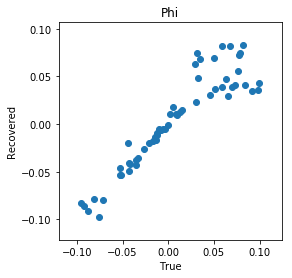

In [51]:
fig,ax = plt.subplots(1,1,figsize=[4,4])
ax.scatter(results['truePhi'],results['recovPhi'])
plt.xlabel('True'); plt.ylabel('Recovered'); plt.title('Phi')

In [52]:
results.to_csv(os.path.join(base_dir,
    'Results/1.Behavior-FitModels/ParameterRecovery/RecoveryStats_57simSubs.csv'))